# Data augmentation and transfer learning {-}

This notebook aims at familiarizing you with training, validating and testing deep neural networks using data augmentation and transfer learning techniques. Here are the BASIC requirements:

- Load the data.
- Process, normalize and resize the images.
- Build a CNN architecture of your choice (from this list of models https://www.tensorflow.org/api_docs/python/tf/keras/applications, except the VGG16 as in the demo code) with an obligatory use of the following two techniques:
    - Data augmentation. Several ideas for the data augmentation: use augmentation layers such as tf.keras.layers.RandomBrightness/RandomContrast/RandomCrop/RandomFlip/RandomHeight/RandomRotation/RandomTranslation/RandomWidth/RandomZoom, etc.
    - Transfer learning. Several ideas for the transfer learning: freeze all layers of the base model, un-freeze some layers of the base model, adjust the classification layers, etc.
- Train and validate the model to perform the image classification task.
- Evaluate the performance of the model on the test set.
- Visualize the model behaviour during the training.

The dataset is tf_flowers (https://www.tensorflow.org/datasets/catalog/tf_flowers) consists of 3,670 files belonging to 5 classes:
* daisy
* dandelion
* roses
* sunflowers
* tulips

# Library and Data Importation

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import Model

In [2]:
# DO NOT CHANGE THIS CODE

#Load the tf_flowers dataset and split training/validation/test set.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # Name of the dataset to load.
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # Split to training, validation and test set.
    with_info=True, # Return the dataset information and keep in 'metadata' variable.
    as_supervised=True,  # boolean, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

# Show the data information (metadata)
print("Metadata: " +str(metadata))

# Show the number of classes of the dataset
num_classes = metadata.features['label'].num_classes
print("Number of classes: " + str(num_classes))

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metadata: tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete1UIJF2',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflo

Image shape: (333, 500, 3)
(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


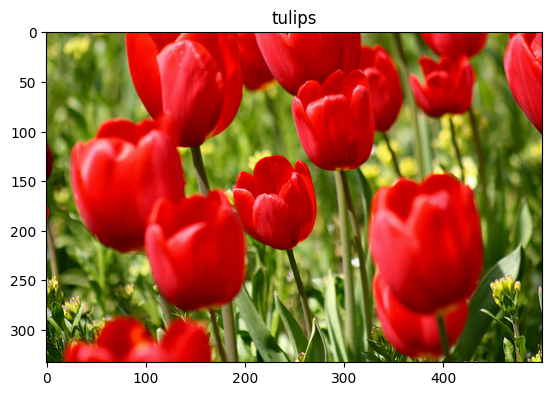

In [3]:
# Show a data sample from the dataset
get_label_name = metadata.features['label'].int2str # Return the function mapping integer label to string label

# Get the first data sample in the training set
image, label = next(iter(train_ds))
plt.imshow(image) # Plot the image.
plt.title(get_label_name(label)) # Add the flower name to the plot.
print("Image shape: " + str(image.shape))

# Print some of image tensors
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

# Data Processing and Augmentation

In [4]:
# Data processing with resizing and resclaing
IMG_SIZE = 96
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE), # Resize the image to a fixed size
  tf.keras.layers.Rescaling(1./255) # Normalize pixel values
])

In [5]:
# Data augmentation with Random Flip and Random Rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"), # Random flip
  tf.keras.layers.RandomRotation(0.2), # Random rotation with angle
  # tf.keras.layers.RandomBrightness(factor=0.2),  # Random brightness augmentation
  tf.keras.layers.RandomContrast(factor=0.2),    # Random contrast augmentation
  tf.keras.layers.RandomCrop(IMG_SIZE, IMG_SIZE),     # Random crop augmentation
  # tf.keras.layers.RandomHeight(factor=0.2),      # Random height augmentation
  # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Random translation augmentation
  # tf.keras.layers.RandomWidth(factor=0.2),       # Random width augmentation
  tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

In [6]:
# Prepare the data: resize and scale, then augment.
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale the dataset 'ds'.
  # lambda is an expression; Input (x is data feature, y is data label); Ouput (only resize and rescale the data feature x).
  # tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=tf.data.AUTOTUNE) # Number data samples to process asynchronously in parallel at a time.

  # shuffle=False by default (i.e., do not shuffle the dataset 'ds' by default)
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)

  # Get a batch_size of data samples from the dataset 'ds'.
  ds = ds.batch(batch_size=1024)

  # augment=False by default (i.e., do not augment the dataset 'ds' by default).
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

  # Prepare the data in the buffer.
  # When tf.data.AUTOTUNE is used, the buffer size is dynamically tuned.
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Resize and rescale the training set; shuffle and augment it.
train_ds = prepare(train_ds, shuffle=True, augment=True)

# Resize and rescale the validation set; DO NOT shuffle and augment it.
val_ds = prepare(val_ds)

# Resize and rescale the test set; DO NOT shuffle and augment it.
test_ds = prepare(test_ds)

Image shape:  (96, 96, 3)


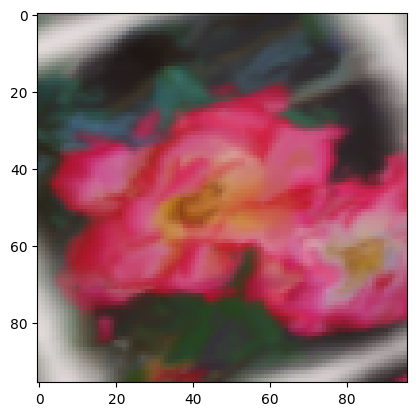

Image shape:  (96, 96, 3)


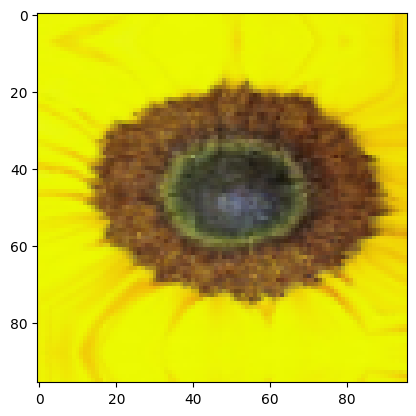

In [8]:
# Plot some data samples in the training data after processing
count = 0
for image_batch in tfds.as_numpy(train_ds):
  if count < 2:
    print("Image shape: ", image_batch[0][count].shape)
    plt.imshow(image_batch[0][count])
    plt.show()
  count = count + 1

# Hyper-parameters for training Densenet 121 models

In [9]:
# Set training epochs and batch size
training_epochs = 150
training_batch_size = 128

dense_unit = 64
dropout = 0.5

# Freeze all layers of the base densenet 121 model

In [10]:
##### Reinitialize the network, i.e., wipe out all trained weights from the previous blocks of code.
# Initialize the model densenet from tf.keras.applications
base_model_densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classifier_activation='softmax')

# Extract the last layer from 4th dense block of densenet model
last_layer = base_model_densenet.get_layer('conv5_block16_concat').output

# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x= BatchNormalization()(x) # Add batch normalization layer.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dropout(dropout)(x) # Add a dropout layer with probability 0.2.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.
##########

# Freeze the base model (feature extraction layers)
base_model_densenet.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_densenet_freeze = Model(inputs=base_model_densenet.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_densenet_freeze.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                             

In [11]:
# Compile the model
complete_model_densenet_freeze.compile(optimizer='adam', # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

# Train the model
history_freeze = complete_model_densenet_freeze.fit(
  train_ds,
  validation_data=val_ds,
  epochs=training_epochs,
  batch_size=training_batch_size
)

Epoch 1/150
3/3 [==============================] - 45s 7s/step - loss: 1.6986 - accuracy: 0.3566 - val_loss: 1.4369 - val_accuracy: 0.5880
Epoch 2/150
3/3 [==============================] - 7s 1s/step - loss: 0.9555 - accuracy: 0.6462 - val_loss: 1.3319 - val_accuracy: 0.7241
Epoch 3/150
3/3 [==============================] - 8s 1s/step - loss: 0.8496 - accuracy: 0.6894 - val_loss: 1.2910 - val_accuracy: 0.7350
Epoch 4/150
3/3 [==============================] - 7s 1s/step - loss: 0.7771 - accuracy: 0.7225 - val_loss: 1.2747 - val_accuracy: 0.7114
Epoch 5/150
3/3 [==============================] - 7s 1s/step - loss: 0.6772 - accuracy: 0.7501 - val_loss: 1.2674 - val_accuracy: 0.7005
Epoch 6/150
3/3 [==============================] - 8s 1s/step - loss: 0.6365 - accuracy: 0.7692 - val_loss: 1.2590 - val_accuracy: 0.7387
Epoch 7/150
3/3 [==============================] - 7s 1s/step - loss: 0.5779 - accuracy: 0.7871 - val_loss: 1.2405 - val_accuracy: 0.7713
Epoch 8/150
3/3 [================

# Un-freeze 50% of the layers of the base densenet 121 model

In [12]:
##### Reinitialize the network, i.e., wipe out all trained weights from the previous blocks of code.
# Initialize the model densenet from tf.keras.applications
base_model_densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classifier_activation='softmax')

# Extract the last layer from third block of densenet model
last_layer = base_model_densenet.get_layer('conv5_block16_concat').output

# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x= BatchNormalization()(x) # Add batch normalization layer.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dropout(dropout)(x) # Add a dropout layer with probability 0.5.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.
##########

# Show the number of layers in the base model
print("Number of layers in the base model: ", len(base_model_densenet.layers))

# Determine the percentage of layers to freeze
freeze_percentage = 0.5

# Fine-tune from this layer onwards
total_layers = len(base_model_densenet.layers)
fine_tune_at = int(freeze_percentage * total_layers)

# Un-freeze only the top layers of the model
base_model_densenet.trainable = True # First, un-freeze all layers of the base model.
for layer in base_model_densenet.layers[:fine_tune_at]: # Then freeze all the layers before the `fine_tune_at` layer
  print("Freeze layer: ", layer.name)
  layer.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_densenet_unfreeze_top = Model(inputs=base_model_densenet.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_densenet_unfreeze_top.summary()

Number of layers in the base model:  427
Freeze layer:  input_2
Freeze layer:  zero_padding2d_2
Freeze layer:  conv1/conv
Freeze layer:  conv1/bn
Freeze layer:  conv1/relu
Freeze layer:  zero_padding2d_3
Freeze layer:  pool1
Freeze layer:  conv2_block1_0_bn
Freeze layer:  conv2_block1_0_relu
Freeze layer:  conv2_block1_1_conv
Freeze layer:  conv2_block1_1_bn
Freeze layer:  conv2_block1_1_relu
Freeze layer:  conv2_block1_2_conv
Freeze layer:  conv2_block1_concat
Freeze layer:  conv2_block2_0_bn
Freeze layer:  conv2_block2_0_relu
Freeze layer:  conv2_block2_1_conv
Freeze layer:  conv2_block2_1_bn
Freeze layer:  conv2_block2_1_relu
Freeze layer:  conv2_block2_2_conv
Freeze layer:  conv2_block2_concat
Freeze layer:  conv2_block3_0_bn
Freeze layer:  conv2_block3_0_relu
Freeze layer:  conv2_block3_1_conv
Freeze layer:  conv2_block3_1_bn
Freeze layer:  conv2_block3_1_relu
Freeze layer:  conv2_block3_2_conv
Freeze layer:  conv2_block3_concat
Freeze layer:  conv2_block4_0_bn
Freeze layer:  conv

In [13]:
# Compile the model
complete_model_densenet_unfreeze_top.compile(optimizer='adam', # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

# Train the model
history_unfreeze_top = complete_model_densenet_unfreeze_top.fit(
  train_ds,
  validation_data=val_ds,
  epochs=training_epochs,
  batch_size=training_batch_size)

Epoch 1/150
3/3 [==============================] - 65s 5s/step - loss: 1.5072 - accuracy: 0.4068 - val_loss: 1.4385 - val_accuracy: 0.6116
Epoch 2/150
3/3 [==============================] - 8s 1s/step - loss: 0.8314 - accuracy: 0.7034 - val_loss: 1.3569 - val_accuracy: 0.6062
Epoch 3/150
3/3 [==============================] - 7s 1s/step - loss: 0.6300 - accuracy: 0.7793 - val_loss: 1.3025 - val_accuracy: 0.5354
Epoch 4/150
3/3 [==============================] - 7s 1s/step - loss: 0.5000 - accuracy: 0.8279 - val_loss: 1.2420 - val_accuracy: 0.5263
Epoch 5/150
3/3 [==============================] - 8s 1s/step - loss: 0.4215 - accuracy: 0.8536 - val_loss: 1.1893 - val_accuracy: 0.5771
Epoch 6/150
3/3 [==============================] - 7s 1s/step - loss: 0.3933 - accuracy: 0.8618 - val_loss: 1.0842 - val_accuracy: 0.7495
Epoch 7/150
3/3 [==============================] - 9s 1s/step - loss: 0.3489 - accuracy: 0.8809 - val_loss: 1.0714 - val_accuracy: 0.7441
Epoch 8/150
3/3 [================

# Adjust the classification layers

In [14]:
##### Reinitialize the network, i.e., wipe out all trained weights from the previous blocks of code.
# Initialize the model densenet from tf.keras.applications
base_model_densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classifier_activation='softmax')

# Extract the last layer from 4th dense block of densenet model
last_layer = base_model_densenet.get_layer('conv5_block16_concat').output

# Add classification layers on top of it
x = GlobalAveragePooling2D()(last_layer) # Convert the last layer to a 1D tensor.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dense(dense_unit, activation='relu')(x) # Add a fully connected layer.
x = Dropout(dropout)(x) # Add a dropout layer with probability 0.2.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.
##########

# Freeze the base model (feature extraction layers)
base_model_densenet.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_densenet_freeze1 = Model(inputs=base_model_densenet.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_densenet_freeze1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 102, 102, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']       

In [15]:
# Compile the model
complete_model_densenet_freeze1.compile(optimizer='adam', # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

# Train the model
history_freeze1 = complete_model_densenet_freeze1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=training_epochs,
  batch_size=training_batch_size
)

Epoch 1/150
3/3 [==============================] - 17s 2s/step - loss: 1.6066 - accuracy: 0.2059 - val_loss: 1.5798 - val_accuracy: 0.4682
Epoch 2/150
3/3 [==============================] - 7s 1s/step - loss: 1.5673 - accuracy: 0.3554 - val_loss: 1.5397 - val_accuracy: 0.5426
Epoch 3/150
3/3 [==============================] - 8s 1s/step - loss: 1.5250 - accuracy: 0.4399 - val_loss: 1.4867 - val_accuracy: 0.5735
Epoch 4/150
3/3 [==============================] - 8s 1s/step - loss: 1.4769 - accuracy: 0.4698 - val_loss: 1.4226 - val_accuracy: 0.6171
Epoch 5/150
3/3 [==============================] - 7s 1s/step - loss: 1.4246 - accuracy: 0.4932 - val_loss: 1.3497 - val_accuracy: 0.6370
Epoch 6/150
3/3 [==============================] - 7s 1s/step - loss: 1.3510 - accuracy: 0.5539 - val_loss: 1.2681 - val_accuracy: 0.6588
Epoch 7/150
3/3 [==============================] - 8s 1s/step - loss: 1.2871 - accuracy: 0.5780 - val_loss: 1.1840 - val_accuracy: 0.6770
Epoch 8/150
3/3 [================

# Visualize and evaluate the performance of the models

In [16]:
def model_evaluation(model):
  # Evaluate the model accuracy using the function model.evaluate()
  model_eval = model.evaluate(train_ds)
  print("List of metrics" + str(model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().
  print("Test loss: " + str(model_eval[0])) # Test loss
  print("Test accuracy: " + str(model_eval[1])) # Test accuracy

def training_visualization(training_history):
  # Visualize the training and validation accuracy over epochs
  plt.plot(training_history.history['accuracy'])
  plt.plot(training_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

1. Freeze all layers of the base model: 
3/3 [==============================] - 6s 883ms/step - loss: 0.0744 - accuracy: 0.9837
List of metrics['loss', 'accuracy']
Test loss: 0.07435162365436554
Test accuracy: 0.9836512207984924


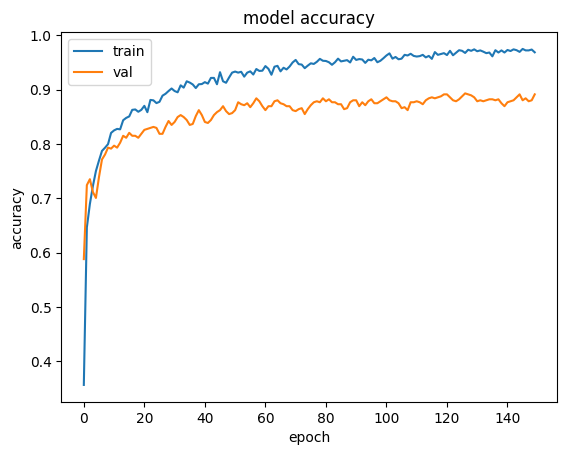


2. Un-freeze 50% of the layers of the base model: 
3/3 [==============================] - 7s 870ms/step - loss: 0.0191 - accuracy: 0.9957
List of metrics['loss', 'accuracy']
Test loss: 0.01912001334130764
Test accuracy: 0.9957181811332703


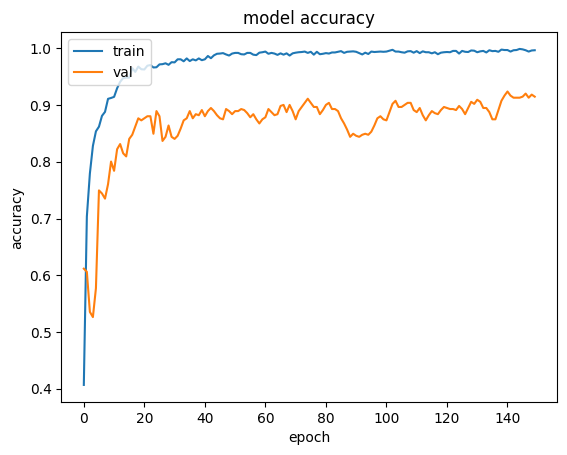


3. Adjust the classification layers of the base model: 
3/3 [==============================] - 8s 1s/step - loss: 0.2744 - accuracy: 0.8996
List of metrics['loss', 'accuracy']
Test loss: 0.274385541677475
Test accuracy: 0.8995718359947205


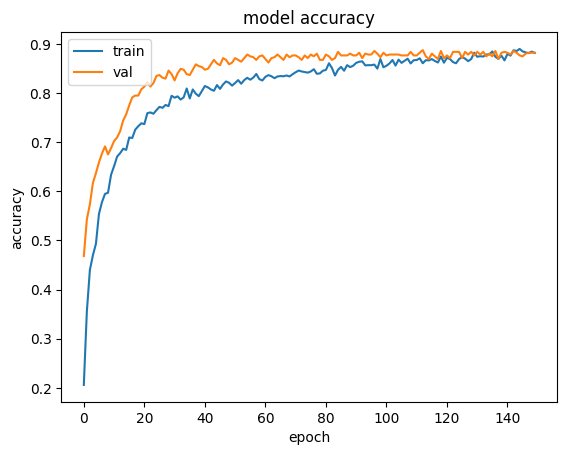

In [17]:
print("1. Freeze all layers of the base model: ")
model_evaluation(complete_model_densenet_freeze)
training_visualization(history_freeze)
print("")
print("2. Un-freeze 50% of the layers of the base model: ")
model_evaluation(complete_model_densenet_unfreeze_top)
training_visualization(history_unfreeze_top)
print("")
print("3. Adjust the classification layers of the base model: ")
model_evaluation(complete_model_densenet_freeze1)
training_visualization(history_freeze1)